### Setup & Imports

In [40]:
# Basic
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import sparse
from sklearn.feature_extraction.text import TfidfVectorizer

# Machine Learning
from sklearn.cluster import MiniBatchKMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

# PSO for optimization
from pyswarm import pso  # Install via: pip install pyswarm

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

### Load Saved Feature Matrix

In [41]:
# Load sparse matrix
final_features = sparse.load_npz("final_features_sparse.npz")
print("Loaded feature matrix shape:", final_features.shape)

# Load original dataset to map cluster labels back to reviews
df = pd.read_csv("processed_reviews.csv")
print("Dataset shape:", df.shape)

Loaded feature matrix shape: (40432, 10001)
Dataset shape: (40432, 3)


### PCA Visualization

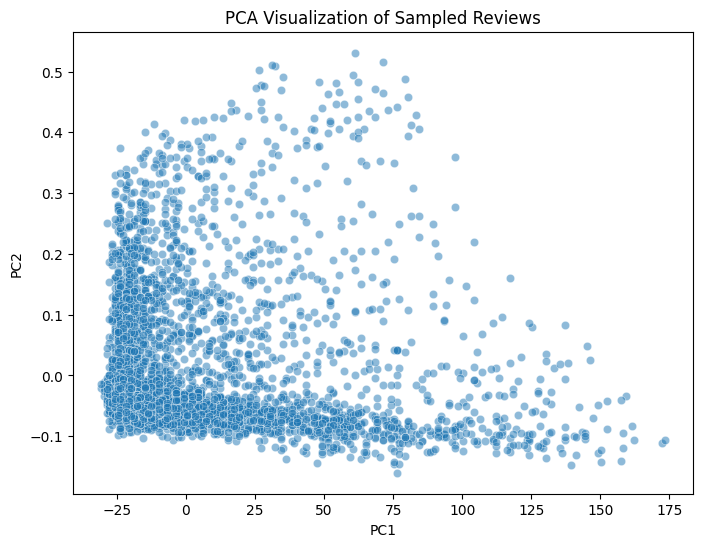

In [42]:
# Convert sparse matrix to dense safely by sampling
sample_size = 5000  # you can adjust this number if needed

if final_features.shape[0] > sample_size:
    # Randomly select 5,000 indices
    sampled_indices = np.random.choice(final_features.shape[0], sample_size, replace=False)
    sampled_features = final_features[sampled_indices].toarray()
    sampled_df = df.iloc[sampled_indices].reset_index(drop=True)
else:
    sampled_features = final_features.toarray()
    sampled_df = df.copy()

# Apply PCA to the sample
pca = PCA(n_components=2)
features_2d = pca.fit_transform(sampled_features)

# Visualization
plt.figure(figsize=(8, 6))
sns.scatterplot(x=features_2d[:, 0], y=features_2d[:, 1], alpha=0.5)
plt.title('PCA Visualization of Sampled Reviews')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

### PSO to Find Optimal Number of Clusters

In [43]:
def objective_function(k):
    """Objective function for PSO: minimize negative silhouette score."""
    k = int(k[0])  # PSO passes a list, extract the value
    if k < 2:
        return 999999  # Prevent invalid cluster count

    km = MiniBatchKMeans(n_clusters=k, random_state=42, batch_size=2048)
    km.fit(final_features)

    # Sample subset to compute silhouette efficiently
    sample_size = min(5000, final_features.shape[0])
    sample_indices = np.random.choice(final_features.shape[0], sample_size, replace=False)

    score = silhouette_score(final_features[sample_indices], km.labels_[sample_indices])
    return -score  # Negative because PSO minimizes

# Bounds for PSO search
lb = [2]   # Lower bound: minimum 2 clusters
ub = [10]  # Upper bound: maximum 10 clusters (adjust as needed)

print("\nRunning PSO optimization to find best number of clusters...")
best_k, best_score = pso(objective_function, lb, ub, swarmsize=10, maxiter=5)
best_k = int(best_k[0])

print(f"\nOptimal number of clusters (best_k): {best_k}")
print(f"Best silhouette score: {-best_score:.4f}")


Running PSO optimization to find best number of clusters...
Stopping search: Swarm best position change less than 1e-08

Optimal number of clusters (best_k): 2
Best silhouette score: 0.7614


### Final K-Means Clustering with Optimal k

In [44]:
print("\nRunning final MiniBatchKMeans with optimal k...")

kmeans_final = MiniBatchKMeans(
    n_clusters=best_k,
    random_state=42,
    batch_size=2048,
    max_iter=100
)
kmeans_final.fit(final_features)

# Assign cluster labels to original dataset
df['cluster'] = kmeans_final.labels_

print("\nFinal cluster distribution:")
print(df['cluster'].value_counts())



Running final MiniBatchKMeans with optimal k...

Final cluster distribution:
cluster
0    34076
1     6356
Name: count, dtype: int64


### Visualize Final Clustering

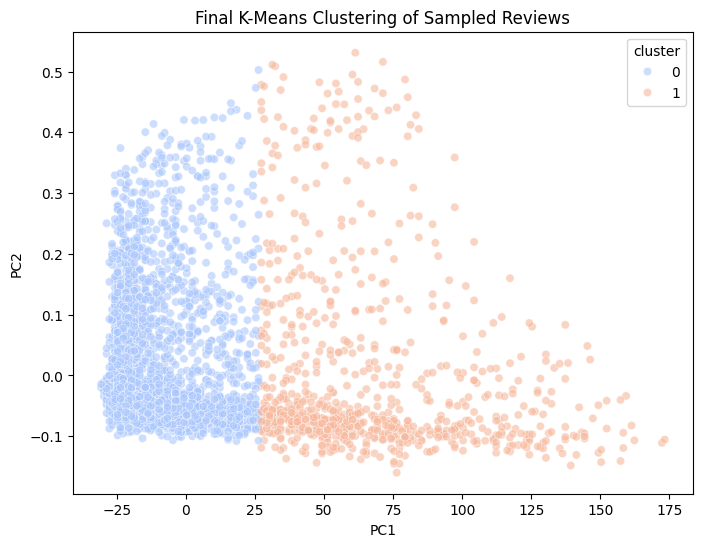

In [45]:
plt.figure(figsize=(8, 6))
sns.scatterplot(
    x=features_2d[:, 0],
    y=features_2d[:, 1],
    hue=df['cluster'].iloc[sampled_indices],
    palette='coolwarm',
    alpha=0.6
)
plt.title('Final K-Means Clustering of Sampled Reviews')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

### Identify Normal vs Anomalous Reviews

In [46]:
# Assume the largest cluster represents "Normal" reviews
largest_cluster = df['cluster'].value_counts().idxmax()

df['review_type'] = df['cluster'].apply(
    lambda x: 'Normal' if x == largest_cluster else 'Anomalous'
)

print("\nNormal vs Anomalous review counts:")
print(df['review_type'].value_counts())


Normal vs Anomalous review counts:
review_type
Normal       34076
Anomalous     6356
Name: count, dtype: int64


### Extract Top Keywords per Cluster

In [47]:
# Convert the string representation of a list into a single string
df['Review_Text_joined'] = df['processed_review'].apply(
    lambda tokens: ' '.join(eval(tokens)) if isinstance(tokens, str) else ' '.join(tokens)
)

# Example
print(df['Review_Text_joined'].head())

0    love well made sturdy comfortable love itvery ...
1     love great upgrade original ive mine couple year
2              pillow saved back love look feel pillow
3          missing information use great product price
4                  nice set good quality set two month
Name: Review_Text_joined, dtype: object


In [48]:
# Fit TF-IDF on the original reviews
vectorizer = TfidfVectorizer()
vectorizer.fit(df['Review_Text_joined'])
feature_names = vectorizer.get_feature_names_out()

# Get cluster centers
centroids = kmeans_final.cluster_centers_

# Function to get top n keywords per cluster
def get_top_keywords_per_cluster(centroids, feature_names, n=10):
    top_keywords = {}
    for i, centroid in enumerate(centroids):
        top_idx = centroid.argsort()[::-1][:n]  # Indices of top n features
        top_keywords[i] = [feature_names[idx] for idx in top_idx]
    return top_keywords

top_keywords = get_top_keywords_per_cluster(centroids, feature_names, n=10)

# Display top keywords for each cluster
print("\nTop keywords per cluster:")
for cluster, keywords in top_keywords.items():
    print(f"Cluster {cluster}: {keywords}")


Top keywords per cluster:
Cluster 0: ['consider', 'bamboo', 'anchovy', '216', 'amazingeverything', 'biorhythm', 'comfortably', 'chalking', 'brillient', 'compliant']
Cluster 1: ['consider', '216', 'biorhythm', 'conan', 'amazingeverything', 'awaiting', 'chalking', 'bamboo', 'anchovy', 'brillient']


### Create Summary Table

In [49]:
cluster_summary = pd.DataFrame({
    'cluster': range(best_k),
    'size': [sum(df['cluster'] == i) for i in range(best_k)],
    'top_keywords': [', '.join(top_keywords[i]) for i in range(best_k)]
})
print("\nCluster Summary:")
print(cluster_summary)


Cluster Summary:
   cluster   size                                       top_keywords
0        0  34076  consider, bamboo, anchovy, 216, amazingeveryth...
1        1   6356  consider, 216, biorhythm, conan, amazingeveryt...


### Save Results

In [50]:
df.to_csv("clustered_reviews.csv", index=False)
print("Clustered dataset saved to clustered_reviews.csv")

Clustered dataset saved to clustered_reviews.csv
